# ROMY & FUR - SHW Maps

## Load Libraries

In [1]:
import os, sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import netCDF4

from obspy import UTCDateTime, read_inventory
from scipy.signal import welch
from pandas import read_pickle, DataFrame, date_range, DateOffset

from functions.get_time_intervals import __get_time_intervals
from functions.load_bathymetry import __load_bathymetry

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
config = {}

config['tbeg'] = UTCDateTime("2023-09-20")
config['tend'] = UTCDateTime("2023-09-27")

# config['tbeg'] = UTCDateTime("2023-12-15")
# config['tend'] = UTCDateTime("2023-12-31")

config['path'] = data_path+"VelocityChanges/data/all/"
# config['path_all'] = data_path+"VelocityChanges/data/all/"

config['path_to_figs'] = data_path+"VelocityChanges/figures/"

config['path_to_bathy_data'] = data_path+"VelocityChanges/data/bathymetry/"

config['romy_lat'], config['romy_lon'] = 48.162941, 11.275501


### Load Data

In [4]:
dates = __get_time_intervals(config['tbeg'], config['tend'], interval_seconds=86400, interval_overlap=0)
# dates = __get_time_intervals(config['tbeg'], config['tbeg']+86400, interval_seconds=86400, interval_overlap=0)


baz_love, baz_rayleigh, baz_tangent, baz_bf = np.array([]), np.array([]), np.array([]), np.array([])
vel_love, vel_rayleigh, vel_bf = np.array([]), np.array([]), np.array([])
std_love, std_rayleigh, std_bf = np.array([]), np.array([]), np.array([])
cc_love, cc_rayleigh, cc_bf, cc_tangent = np.array([]), np.array([]), np.array([]), np.array([])
ttt, ttt_bf = np.array([]), np.array([])

for _n, (d1, d2) in enumerate(dates):

    filename = f"VC_BAZ_{d1.date}_all.pkl"

    if os.path.isfile(config['path']+filename):
        print(f"loading: {filename}")
        out = read_pickle(config['path']+filename)
    else:
        print(f"-> no file for {filename}")

    # print(out.keys())

    try:
        vel_love = np.append(vel_love, out['vel_love_all'])
        vel_rayleigh = np.append(vel_rayleigh, out['vel_rayleigh_all'])
        vel_bf = np.append(vel_bf, out['vel_bf_all'])

        baz_love = np.append(baz_love, out['baz_love_all'])
        baz_rayleigh = np.append(baz_rayleigh, out['baz_rayleigh_all'])
        baz_tangent = np.append(baz_tangent, out['baz_tangent_all'])
        baz_bf = np.append(baz_bf, out['baz_bf_all'])

        cc_love = np.append(cc_love, out['cc_love_all'])
        cc_rayleigh = np.append(cc_rayleigh, out['cc_rayleigh_all'])
        cc_tangent = np.append(cc_tangent, out['cc_tangent_all'])


        ttt = np.append(ttt, out['time'])
        ttt_bf = np.append(ttt_bf, out['time_bf'])

    except:
        print(f" -> skipping: {filename}")
        continue

## remove nan values based on time array
# bad = []
# for _i, tt in enumerate(ttt):
#     if str(type(tt)) != "<class 'obspy.core.utcdatetime.UTCDateTime'>":
#         bad.append(_i)



loading: VC_BAZ_2023-09-20_all.pkl
loading: VC_BAZ_2023-09-21_all.pkl
loading: VC_BAZ_2023-09-22_all.pkl
loading: VC_BAZ_2023-09-23_all.pkl
loading: VC_BAZ_2023-09-24_all.pkl
loading: VC_BAZ_2023-09-25_all.pkl
-> no file for VC_BAZ_2023-09-26_all.pkl


### Make DataFrames

In [5]:
## _____________________________
df_rayleigh = DataFrame()

df_rayleigh['time'] = ttt
df_rayleigh['cc'] = cc_rayleigh
df_rayleigh['vel'] = vel_rayleigh
df_rayleigh['baz'] = baz_rayleigh


df_rayleigh = df_rayleigh.dropna(subset=['time']).reset_index()

df_rayleigh['time_relative'] = df_rayleigh.time - df_rayleigh.time.iloc[0]

## _____________________________
df_love = DataFrame()

df_love['time'] = ttt
df_love['cc'] = cc_love
df_love['vel'] = vel_love
df_love['baz'] = baz_love

df_love = df_love.dropna(subset=['time']).reset_index()

df_love['time_relative'] = df_love.time - df_love.time.iloc[0]

## _____________________________
df_tangent = DataFrame()

df_tangent['time'] = ttt
df_tangent['cc'] = cc_tangent
df_tangent['baz'] = baz_tangent

df_tangent = df_tangent.dropna(subset=['time']).reset_index()

df_tangent['time_relative'] = df_tangent.time - df_tangent.time.iloc[0]

## _____________________________
df_bf = DataFrame()

df_bf['time'] = ttt_bf
df_bf['baz'] = baz_bf
df_bf['vel'] = vel_bf

df_bf = df_bf.dropna(subset=['time']).reset_index()

df_bf['time_relative'] = df_bf.time - df_bf.time.iloc[0]


#### Filter Frames

In [6]:
cc_threshold = 0.7

df_tangent = df_tangent[df_tangent.cc > cc_threshold]
df_rayleigh = df_rayleigh[df_rayleigh.cc > cc_threshold]
df_love = df_love[df_love.cc > cc_threshold]
# df_bf = df_bf[df_bf.cc > cc_threshold]


### Load SWH Maps

In [7]:
path_to_swh_data = data_path+"VelocityChanges/data/SWH/"

f = netCDF4.Dataset(path_to_swh_data+'cmems_obs-wave_glo_phy-swh_nrt_multi-l4-2deg_P1D.nc')

# f.variables.keys()

dict_keys(['VAVH_DAILY_MAX', 'VAVH_DAILY_MEAN', 'VAVH_DAILY_NBR', 'VAVH_DAILY_STD', 'VAVH_INST', 'VAVH_INST_NBR', 'VAVH_INST_SCORE', 'latitude', 'longitude', 'time'])

In [8]:
lat, lon = f.variables['latitude'], f.variables['longitude']

img = f.variables['VAVH_DAILY_MEAN'][10].data

# plt.pcolormesh(lon[:], lat[:], img, shading="auto")

### Load Bathymetry Data

In [10]:
box = [config['romy_lon']-40, config['romy_lon']+40, config['romy_lat']-40, config['romy_lat']+40]

out_bath = __load_bathymetry(config['path_to_bathy_data'], (box[0], box[2], box[1], box[3]))


## Plot on Map

In [19]:
def circular_hist(ax, x, nbins=72, density=True, offset=0, gaps=True, weights=None):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    import numpy as np

    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        nbins = np.linspace(-np.pi, np.pi, num=nbins+1)

    # Bin data and record counts
    if weights is not None:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi), weights=weights)
    else:
        n, bins = np.histogram(x, bins=nbins, range=(-np.pi, np.pi))

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths, alpha=0.6,
                     edgecolor='darkred', facecolor='darkred', fill=False, linewidth=0.8, bottom=1.0)
    # patches = ax.bar(bins[:-1], radius, zorder=2, align='edge', width=widths, alpha=0.6,
    #                  edgecolor='k', facecolor='darkred', fill=True, linewidth=0.5, bottom=1.0)

    # Set the direction of the zero angle
    # ax.set_theta_offset(offset)
    ax.set_theta_zero_location("N")  # theta=0 at the top

    ax.set_theta_direction(-1)  # theta increasing clockwise

    ax.grid(zorder=0)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [20]:
def __makeplot_swh_maps(density=True):

    import cartopy.feature as cfeature
    import cartopy.crs as ccrs

    font = 12

    fig = plt.figure(figsize=(15, 15), dpi=96)

    fig.subplots_adjust(hspace=-0.2, wspace=0.1)


    ## ------------------------------------------------------------------------------
    ## CoVar

    ax0 = fig.add_subplot(221, projection=ccrs.PlateCarree(), frame_on=False)

    ax0.pcolormesh(lon, lat, img, transform=ccrs.PlateCarree(), alpha=0.9, zorder=0)
    ax0.add_feature(cfeature.LAND, color='grey', zorder=1)
    ax0.coastlines(zorder=1)

    # ax0.set_xlim(config['romy_lon']-60, config['romy_lon']+60)
    # ax0.set_ylim(config['romy_lat']-60, config['romy_lat']+60)


    ax00 = fig.add_subplot(221, projection='polar', frame_on=True)

    circular_hist(ax00, np.deg2rad(df_tangent0.baz), density=True, weights=df_tangent0.cc)

    # ax0.scatter(config['romy_lon'], config['romy_lat'], zorder=10, s=50, color="w")


    ## ------------------------------------------------------------------------------
    ## CoVar

    ax1 = fig.add_subplot(222, projection=ccrs.PlateCarree(), frame_on=False)

    ax1.pcolormesh(lon, lat, img, transform=ccrs.PlateCarree(), alpha=0.9, zorder=0)
    ax1.add_feature(cfeature.LAND, color='grey', zorder=1)
    ax1.coastlines(zorder=1)

    ax11 = fig.add_subplot(222, projection='polar', frame_on=True)

    # circular_hist(ax11, np.deg2rad(df_bf0.baz), density=True, weights=df_bf0.cc)
    circular_hist(ax11, np.deg2rad(df_bf0.baz), density=True, weights=None)


    ## ------------------------------------------------------------------------------
    ## CoVar

    ax2 = fig.add_subplot(223, projection=ccrs.PlateCarree(), frame_on=False)

    ax2.pcolormesh(lon, lat, img, transform=ccrs.PlateCarree(), alpha=0.9, zorder=0)
    ax2.add_feature(cfeature.LAND, color='grey', zorder=1)
    ax2.coastlines(zorder=1)

    ax22 = fig.add_subplot(223, projection='polar', frame_on=True)

    circular_hist(ax22, np.deg2rad(df_love0.baz), density=True, weights=df_love0.cc)

    ## ------------------------------------------------------------------------------
    ## CoVar

    ax3 = fig.add_subplot(224, projection=ccrs.PlateCarree(), frame_on=False)

    ax3.pcolormesh(lon, lat, img, transform=ccrs.PlateCarree(), alpha=0.9, zorder=0)
    ax3.add_feature(cfeature.LAND, color='grey', zorder=1)
    ax3.coastlines(zorder=1)

    ax33 = fig.add_subplot(224, projection='polar', frame_on=True)

    circular_hist(ax33, np.deg2rad(df_rayleigh0.baz), density=True, weights=df_rayleigh0.cc)

    ## ------------------------------------------------------------------------------

    for _ax in [ax00, ax11, ax22, ax33]:
        _ax.patch.set_alpha(0.)
        _ax.grid(color="k", ls="--", alpha=0.5)
        _ax.set_zorder(5)

        _pos = _ax.get_position()
        _ax.set_position([_pos.x0+0.092, _pos.y0+0.08, _pos.width*0.65, _pos.height*0.65])


    ax0.set_title("(a) Co-Variance", pad=5, loc="left", fontsize=font)
    ax1.set_title("(b) Beamforming", pad=5, loc="left", fontsize=font)
    ax2.set_title("(c) Love waves", pad=5, loc="left", fontsize=font)
    ax3.set_title("(d) Rayleigh waves", pad=5, loc="left", fontsize=font)

    plt.suptitle(f"Backazimuth Estimation:  BW.ROMY - GR.FUR  {str(dat)[:10]}",
                 fontsize=font+1, y=0.86)

    # gc.collect()

    plt.show();
    return fig

# fig = __makeplot_swh_maps(density=True)


### Loop

2023-09-20 00:00:00 19


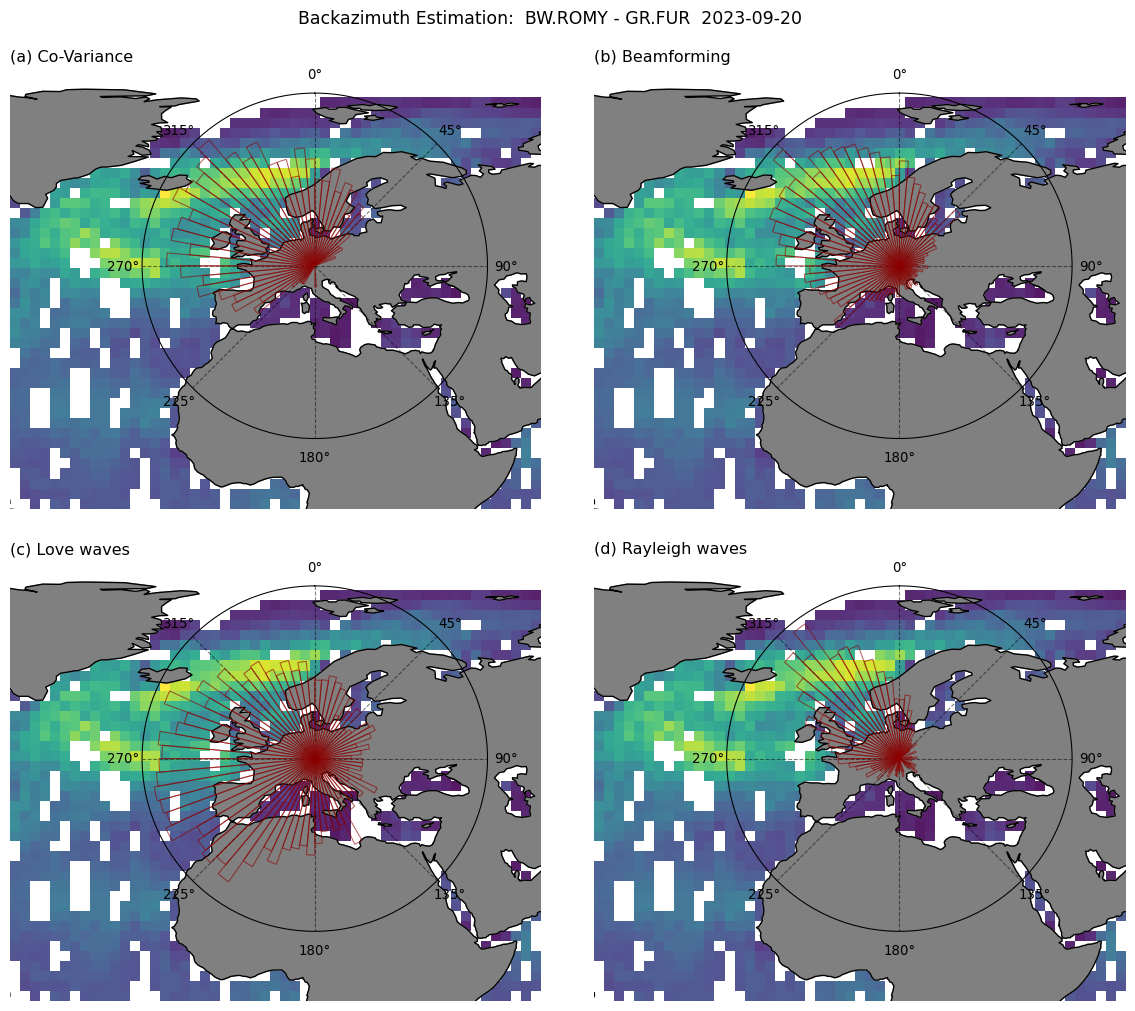

2023-09-21 00:00:00 20


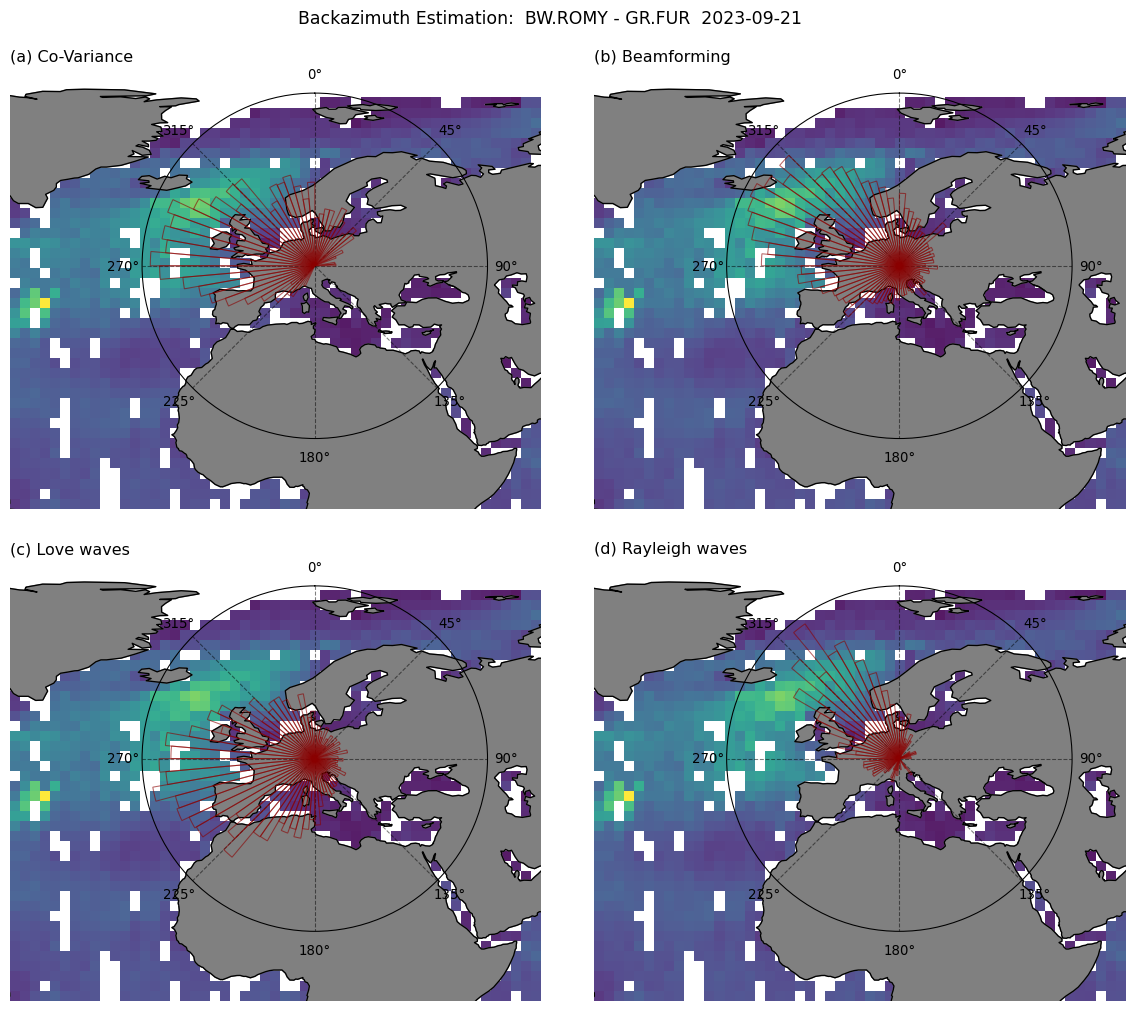

2023-09-22 00:00:00 21


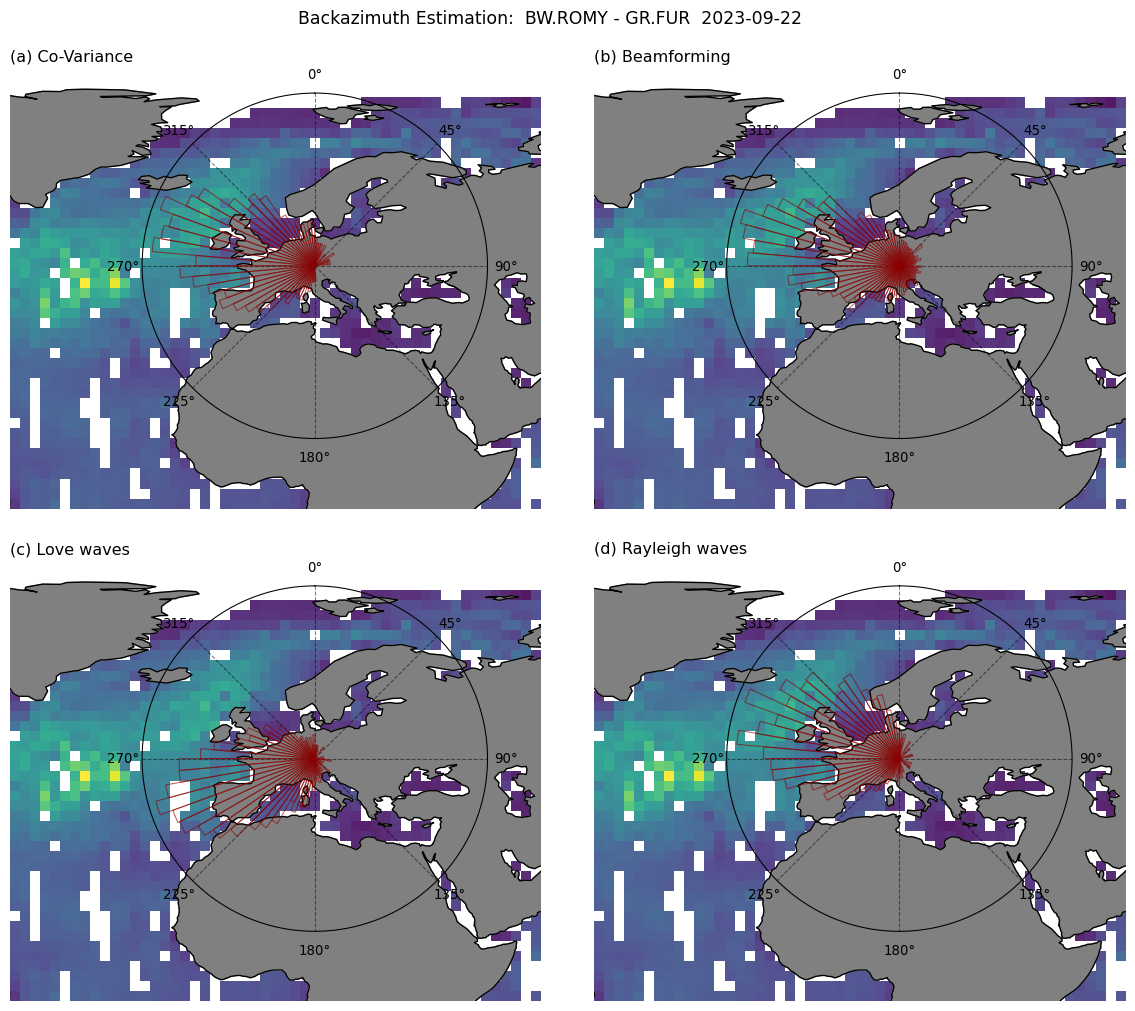

2023-09-23 00:00:00 22


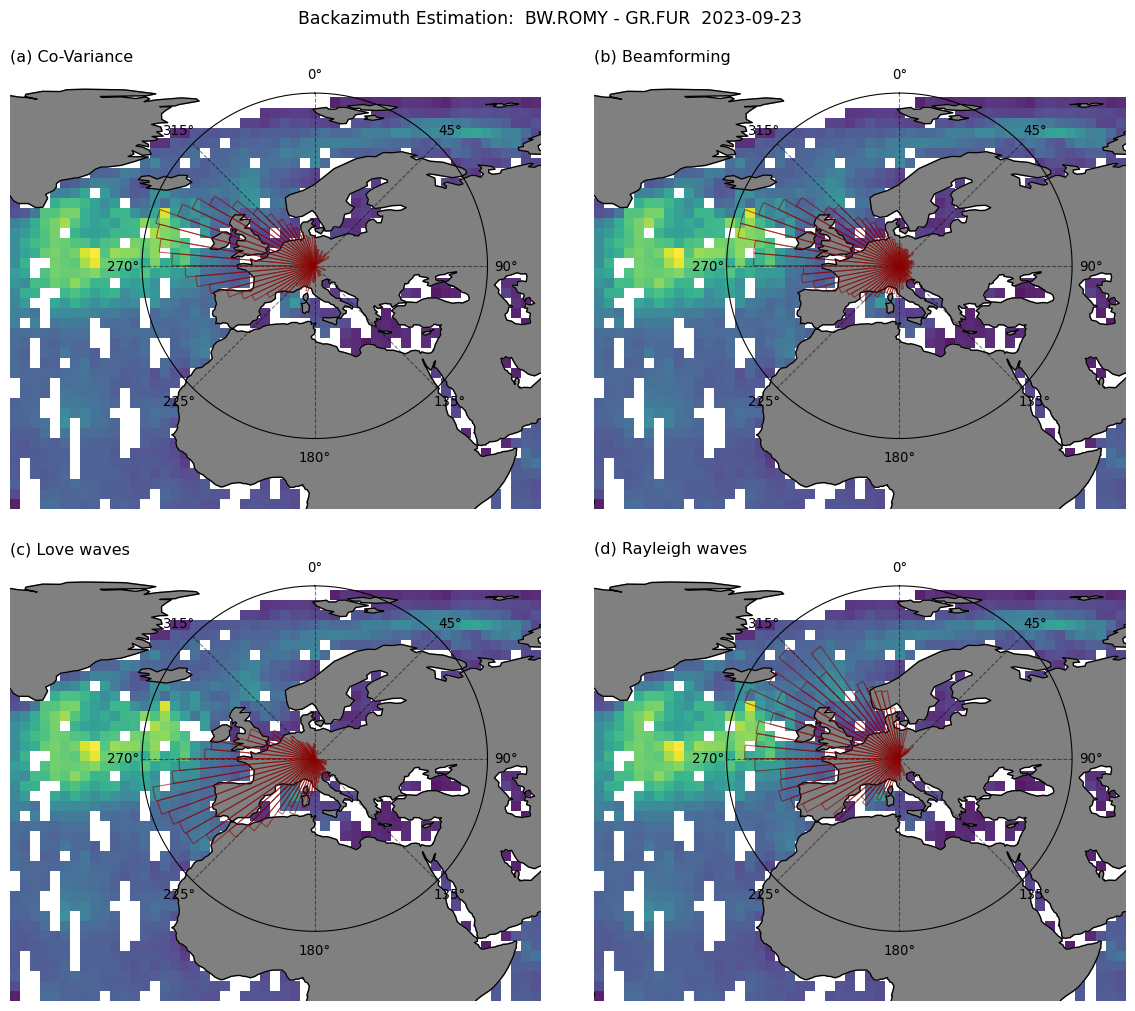

2023-09-24 00:00:00 23


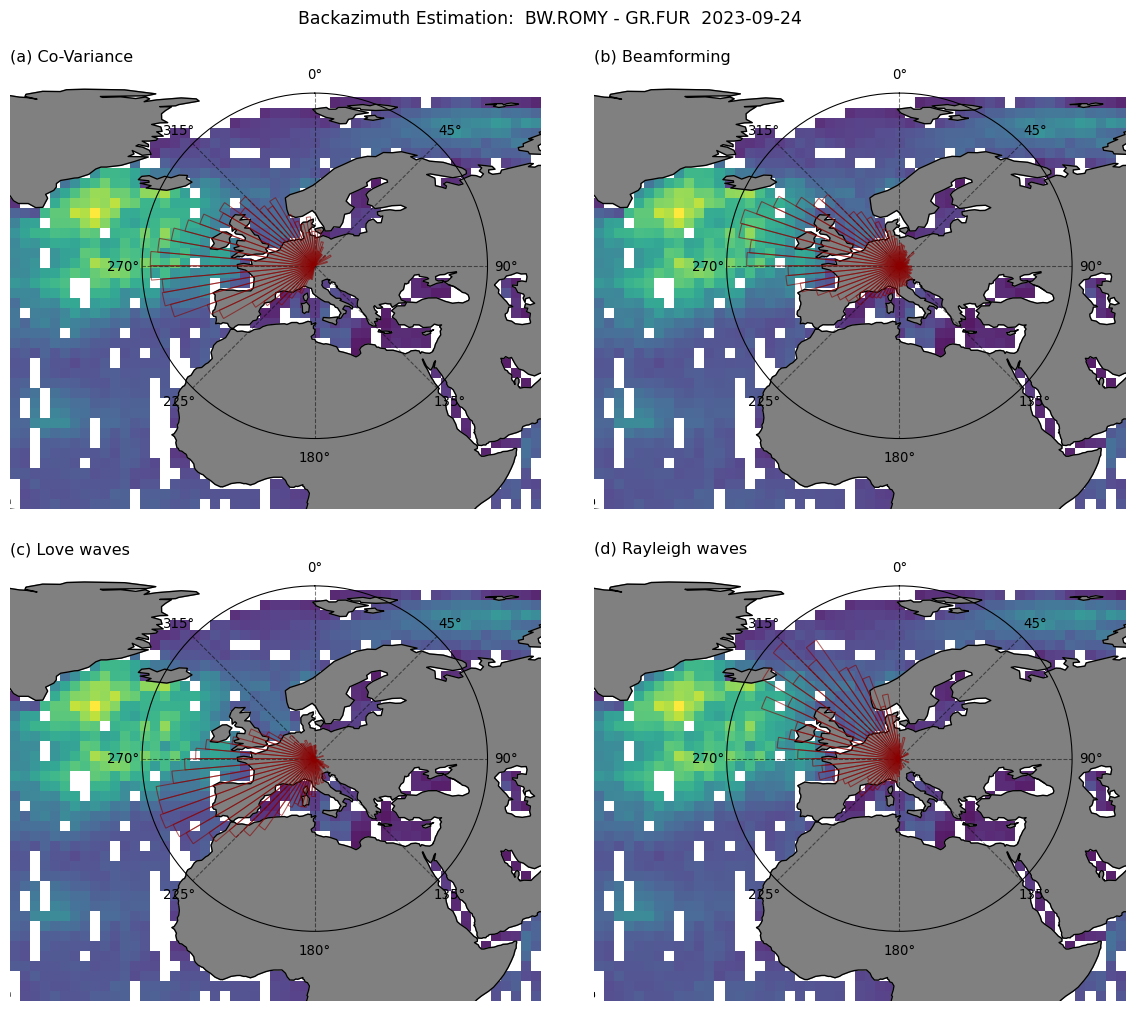

2023-09-25 00:00:00 24


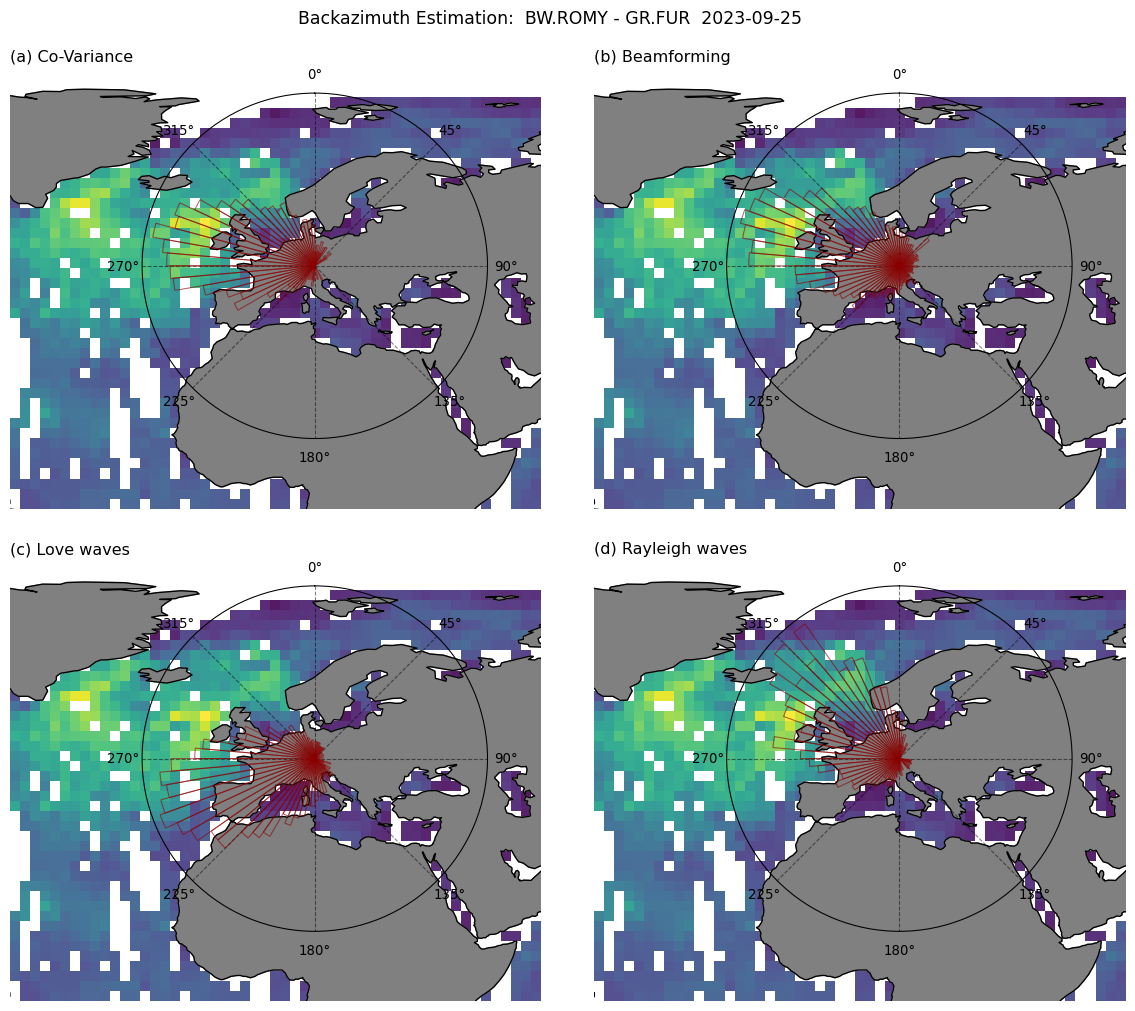

2023-09-26 00:00:00 25


/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size
/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size
/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size
/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size


ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

<Figure size 1440x1440 with 8 Axes>

2023-09-27 00:00:00 26


/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size
/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size
/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size
/tmp/ipykernel_483224/3004014140.py:61: RuntimeWarning: invalid value encountered in divide
  area = n / x.size


ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

<Figure size 1440x1440 with 8 Axes>

In [22]:
dates = date_range(str(config['tbeg'].date), str(config['tend'].date))

for dat in dates:

    sec = abs(UTCDateTime("1970-01-01") - UTCDateTime(str(dat)))

    idx_time = netCDF4.date2index(dat, f.variables['time'], select='nearest')

    print(dat, idx_time)

    try:
        img = f.variables['VAVH_DAILY_MEAN'][idx_time].data

        df_tangent0 = df_tangent[(df_tangent.time > dat) & (df_tangent.time < dat + DateOffset(1))]
        df_bf0 = df_bf[(df_bf.time > dat) & (df_bf.time < dat + DateOffset(1))]
        df_love0 = df_love[(df_love.time > dat) & (df_love.time < dat + DateOffset(1))]
        df_rayleigh0 = df_rayleigh[(df_rayleigh.time > dat) & (df_rayleigh.time < dat + DateOffset(1))]

        fig = __makeplot_swh_maps(density=True)

        fig.savefig(config['path_to_figs']+"SWH/"+f"BAZ_SWH_{str(dat)[:10]}.png", format="png", dpi=150, bbox_inches='tight')

    except:
        pass